# Question 4: Backtesting

Objective: \
Demonstrate understanding of how to implement and backtest a trading strategy.

Backtest either: \
RSI or MACD strategies .
Show PnL, annualised sharpe ratio, and drawdown over time.
Make your code as effieicent (vectorized) as possible.

## Solution:
For this task, I decided to use a single metal (e.g., COPPER) and focus solely on the MACD, rather than combining it with the RSI. The strategy is based on the MACD crossing its signal line: when the MACD line crosses above the signal line, one unit is bought, and when it crosses below the signal line, all held units are sold. In the final version of this strategy, only one unit is held at a time. However, since I tested different strategies, I wrote the backtesting code to be easily adaptable to buying multiple units before selling. Once the strategy enters a ‘selling’ state, it sells all held units/positions.

I also tried combining the simple MACD crossing strategy with an RSI check, so that it only ‘buys’ when the RSI indicates an oversold state and only ‘sells’ when the RSI indicates an overbought state. However, this strategy produced very few trades (around 3) over the 2-year period. Although all the trades were profitable for both metals, I preferred to share the results of a backtested strategy that generated a larger number of trades, as it is a more robust test.

I saved the results of the backtesting in three .csv tables in the folder ‘solutions/tables/’. The three tables are:
- simulation_results.csv:
    - Contains the columns: Date, Price, Free Capital, Held Positions, Invested Capital, Daily Returns, Drawdown
	- This table contains the information of the backtest for each time point.
- trades_results.csv:
	- Contains the columns: Entry Date, Exit Date, Entry Price, Exit Price, Profit
	- This table contains the information for each held position.
- performance_metric.csv:
	- Contains the columns: From Date, To Date, Number of Trades, PnL, Sharpe Ratio, Max Drawdown (%), Profitable Trades (%)
	- I chose three periods: 2020, 2021, and the combined 2-year period.


In [8]:
import os
import sqlite3
import time
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

### Functions to handle the database interaction ###


def log_execution(func):
    def wrapper(*args, **kwargs):
        if func.__name__ == "get_metal_data":
            logging.info(f"Getting data for {args[0]} from {args[1]} to {args[2]}.")
        else:
            logging.info(
                f"Running function {func.__name__} with arguments: {args} and keyword arguments: {kwargs}."
            )
        start_execution = time.time()
        result = func(*args, **kwargs)
        end_execution = time.time()
        logging.info(
            f"Finished execution of {func.__name__} in {end_execution - start_execution:.2f} seconds.\n"
        )
        return result

    return wrapper


@log_execution
def get_metal_data(metal: str, start_date: str, end_date: str) -> pd.DataFrame:
    """Returns a DataFrame with the metal prices and indicators for a given date range.
    INPUTs:
    - metal: string, name of the metal (e.g. 'COPPER')
    - start_date, end_date: strings, dates in the format 'YYYY-MM-DD'
    OUTPUTs:
    - df: DataFrame with the metal prices and indicators
    """
    try:
        conn = sqlite3.connect(f"{os.pardir}/market_data.db")
        cur = conn.cursor()
        # Get column names dynamically from the database schema
        column_query = "PRAGMA table_info(MetalPrices);"
        cur.execute(column_query)
        columns_info = cur.fetchall()
        column_names = [column[1] for column in columns_info]
        # Get the data for the specified metal and date range
        cur.execute(
            """
            SELECT * FROM MetalPrices
            WHERE Metal = ? AND Date >= ? AND Date <= ?
            ORDER BY Date
        """,
            (metal, start_date, end_date),
        )
        # Fetch all results and create a DataFrame
        df = pd.DataFrame(cur.fetchall(), columns=column_names)
        df["Date"] = pd.to_datetime(df["Date"])
        if len(df) == 0:
            logging.warning(
                f"No data found for {metal} between {start_date} and {end_date}."
            )
        cur.close()
    except sqlite3.Error as e:
        logging.error(f"An error occurred while fetching data from the database: {e}")
        df = None
    finally:
        if conn:
            conn.close()
    return df


### Functions for backtesting the strategy ###


def backtest_simulation(
    df: pd.DataFrame, free_capital: float = 10000
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Backtest a trading strategy using the MACD indicator. When the MACD line crosses above the signal line (9 period EMA of the MACD line), a buy signal is generated. When the MACD line crosses below the signal line, a sell signal is generated. Assumes no transaction costs.
    INPUTs:
    - df: DataFrame with the metal prices and indicators, columns should include: ['Date', 'Price', 'MACD']
    - free_capital: float, initial amount of capital available for trading.
    OUTPUTs:
    - df_simulation: DataFrame with the simulation results over each time period
    - df_trades: DataFrame with the trades made during the simulation
    """
    # Initial values for the simulation
    held_positions, invested_value = 0, 0
    # Used to save the simulation results
    hist_free_capital, hist_held_positions, hist_invested_value = [], [], []
    # Used to save the trades made during the simulation
    hist_entry_dates, hist_exit_dates, hist_entry_prices, hist_exit_prices = (
        [],
        [],
        [],
        [],
    )

    # Calculate the signal line of the MACD
    signal = df["MACD"].ewm(span=9, adjust=False).mean()
    MACD_crosses_signal = (df["MACD"] > signal).astype(int).diff().fillna(0)
    # Iterate over each time period
    for idx in df.index:
        # Buy
        if MACD_crosses_signal[idx] > 0:
            # Check non-negative value
            if free_capital - df["Price"][idx] < 0:
                logging.warning(
                    f"Not enough free capital to buy at {df['Price'][idx]} on {df['Date'][idx]}. Should start with more capital for a better simulation."
                )
            else:
                # Simulation values
                held_positions += 1
                free_capital -= df["Price"][idx]
                invested_value += df["Price"][idx]
                # Trade values
                hist_entry_dates.append(df["Date"][idx])
                hist_entry_prices.append(df["Price"][idx])

        # Sell
        elif (held_positions > 0) & (MACD_crosses_signal[idx] < 0):
            # Trades values
            for _ in np.arange(held_positions):
                hist_exit_dates.append(df["Date"][idx])
                hist_exit_prices.append(df["Price"][idx])
            # Simulation values
            free_capital += df["Price"][idx] * held_positions
            held_positions = 0
            invested_value = 0

        # Hold
        else:
            # Invested capital changes daily
            invested_value = df["Price"][idx] * held_positions

        # Update portfolio value
        hist_free_capital.append(free_capital)
        hist_held_positions.append(held_positions)
        hist_invested_value.append(invested_value)

    # Save the simulation results
    df_simulation = pd.DataFrame(
        {
            "Date": df["Date"],
            "Price": df["Price"],
            "Free Capital": hist_free_capital,
            "Held Positions": hist_held_positions,
            "Invested Capital": hist_invested_value,
        }
    )

    # If a trade was entered before the end of the simulation, remove it
    if held_positions > 0:
        # From the last entry date to the end of the simulation update the Free Capital, Held Positions and Invested Capital
        date = hist_entry_dates[-held_positions]
        idx = df_simulation[df_simulation["Date"] == date].index[0]
        df_simulation.loc[
            idx:, ["Free Capital", "Held Positions", "Invested Capital"]
        ] = [df_simulation.loc[idx - 1, "Free Capital"], 0, 0]
        # Remove the last entry dates and and prices that were not closed
        hist_entry_dates = hist_entry_dates[:-held_positions]
        hist_entry_prices = hist_entry_prices[:-held_positions]

    df_trades = pd.DataFrame(
        {
            "Entry Date": hist_entry_dates,
            "Exit Date": hist_exit_dates,
            "Entry Price": hist_entry_prices,
            "Exit Price": hist_exit_prices,
        }
    )
    df_trades["Profit"] = df_trades["Exit Price"] - df_trades["Entry Price"]

    return df_simulation, df_trades


### Functions for performance metrics ###


def calculate_daily_returns(df: pd.DataFrame) -> None:
    """Calculate daily returns of the portfolio based on Free Capital and Invested Capital combined. Adds a new column 'Daily Returns' to the DataFrame.
    INPUTs:
    - df: DataFrame of the simulation with columns 'Free Capital' and 'Invested Capital'.
    """
    portfolio_value = df["Free Capital"] + df["Invested Capital"]
    df["Daily Returns"] = portfolio_value.pct_change().fillna(0)
    return None


def calculate_PnL(df: pd.DataFrame) -> float:
    """Calculate profit and loss (PnL) of the portfolio.
    INPUTs:
    - df: DataFrame of the trades with column 'Profit'.
    OUTPUTs:
    - PnL: float, profit and loss of the portfolio. Returns None if no trades were made, np.inf if only profitable trades were made, and -np.inf if only loss trades were made.
    """
    n_profitable_trades = len(df[df["Profit"] > 0])
    n_loss_trades = len(df[df["Profit"] < 0])
    total_profit = df[df["Profit"] > 0]["Profit"].sum()
    total_loss = -df[df["Profit"] < 0]["Profit"].sum()
    # Case only profitable trades
    if (n_profitable_trades != 0) & (n_loss_trades == 0):
        return np.inf
    # Case only loss trades
    elif (n_profitable_trades == 0) & (n_loss_trades != 0):
        return -np.inf
    # Case no trades
    elif (n_profitable_trades == 0) & (n_loss_trades == 0):
        return None
    # Standard case
    else:
        PnL = (total_profit / n_profitable_trades) / (total_loss / n_loss_trades)
        return PnL


def calculate_perc_profitable_trades(df: pd.DataFrame) -> float:
    """Calculate the percentage of profitable trades.
    INPUTs:
    - df: DataFrame of the trades with column 'Profit'.
    OUTPUTs:
    - perc_profitable_trades: float, percentage of profitable trades, returns None if no trades were made.
    """
    n_profitable_trades = len(df[df["Profit"] > 0])
    n_loss_trades = len(df[df["Profit"] < 0])
    # Case of no trades
    if n_profitable_trades + n_loss_trades == 0:
        return None
    else:
        perc_profitable_trades = n_profitable_trades / (
            n_profitable_trades + n_loss_trades
        )
        return perc_profitable_trades


def calculate_sharpe_ratio(df: pd.DataFrame) -> float:
    """Calculate the Sharpe ratio over the provided period of time.
    INPUTs:
    - df: DataFrame of the simulation with column 'Daily Returns'.
    OUTPUTs:
    - sharpe_ratio: float, Sharpe ratio of the portfolio, returns None if there is no invested capital (0 daily returns).
    """
    avg_daily_returns = df["Daily Returns"].mean()
    std_daily_returns = df["Daily Returns"].std()
    # Case of no invested capital
    if std_daily_returns == 0:
        return None
    else:
        sharpe_ratio = (avg_daily_returns / std_daily_returns) * np.sqrt(len(df))
        return sharpe_ratio


def calculate_drawdown(df: pd.DataFrame) -> None:
    """Calculate the drawdown of the portfolio over time (percentage). Adds a new column 'Drawdown' to the DataFrame.
    INPUTs:
    - df: DataFrame of the simulation with column 'Free Capital' and 'Invested Capital'.
    """
    portfolio_value = df["Free Capital"] + df["Invested Capital"]
    rolling_max = portfolio_value.cummax()
    df["Drawdown"] = ((portfolio_value - rolling_max) / rolling_max) * 100
    return None


def calculate_max_drawdown(df: pd.DataFrame) -> float:
    """Returns the maximum drawdown of the portfolio over time (percentage).
    INPUTs:
    - df: DataFrame of the simulation with column 'Drawdown'.
    OUTPUTs:
    - max_drawdown: float, maximum drawdown of the portfolio over the provided period of time.
    """
    max_drawdown = df["Drawdown"].min()
    return max_drawdown


def get_performance_metrics_table(
    df_simulation: pd.DataFrame, df_trades: pd.DataFrame, periods: list[tuple[str, str]]
) -> pd.DataFrame:
    """Create a table with the performance metrics for each period. Table includes: Number of trades, PnL, Sharpe ratio, maximum drawdown, and percentage of profitable trades.
    INPUTs:
    - df_simulation: DataFrame of the simulation with columns 'Free Capital', 'Invested Capital', and 'Daily Returns'.
    - df_trades: DataFrame of the trades with columns 'Entry Date', 'Exit Date', 'Entry Price', and 'Exit Price'.
    - periods: list of tuples with the start and end dates for each period.
    OUTPUTs:
    - df_performance: DataFrame with the performance metrics for each period.
    """
    # To store results for performance table
    n_trades, PnLs, sharpe_ratios, max_drawdowns, perc_profitable_trades = (
        [],
        [],
        [],
        [],
        [],
    )
    # Iterate over each period
    for start_date, end_date in periods:
        # Select the data for a period
        sel_df_simulation = df_simulation[
            (df_simulation["Date"] >= start_date) & (df_simulation["Date"] <= end_date)
        ]
        sel_df_trades = df_trades[
            (df_trades["Entry Date"] >= start_date)
            & (df_trades["Exit Date"] <= end_date)
        ]
        # Calculate the performance metrics
        n_trades.append(len(sel_df_trades))
        PnLs.append(calculate_PnL(sel_df_trades))
        sharpe_ratios.append(calculate_sharpe_ratio(sel_df_simulation))
        max_drawdowns.append(calculate_max_drawdown(sel_df_simulation))
        perc_profitable_trades.append(calculate_perc_profitable_trades(sel_df_trades))

    # Create a DataFrame with the performance metrics
    df_performance = pd.DataFrame(
        {
            "From Date": [f"{start}" for start, _ in periods],
            "To Date": [f"{end}" for _, end in periods],
            "Number of Trades": n_trades,
            "PnL": PnLs,
            "Sharpe Ratio": sharpe_ratios,
            "Max Drawdown (%)": max_drawdowns,
            "Profitable Trades (%)": perc_profitable_trades,
        }
    )
    return df_performance


### Functions for plotting ###


def plot_drawdown_overtime(df_simulation: pd.DataFrame, metal: str) -> None:
    """Plot the drawdown over time for the simulation results.
    INPUTs:
    - df_simulation: DataFrame of the simulation with columns 'Date', 'Free Capital', 'Invested Capital', and 'Drawdown'.
    - metal: string, name of the metal (e.g. 'COPPER')
    """
    # Visualise the Drawdown over time
    fig = plt.figure(figsize=(14, 7))
    fig.suptitle(
        f"Portfolio Value (free + invested capital) and Drawdown Over Time, when trading {metal}"
    )
    grid = fig.add_gridspec(nrows=2, ncols=1, hspace=0)

    ax = fig.add_subplot(grid[0, 0])
    ax.plot(
        df_simulation["Date"],
        df_simulation["Free Capital"] + df_simulation["Invested Capital"],
        label="Portfolio Value",
    )
    ax.set_ylabel("Portfolio Value ($)")
    ax.legend(loc="upper left")

    ax = fig.add_subplot(grid[1, 0])
    ax.plot(
        df_simulation["Date"], df_simulation["Drawdown"], label="Drawdown", color="red"
    )
    ax.set_ylabel("Drawdown (%)")
    ax.set_xlabel("Date")
    ax.legend(loc="lower left")
    plt.show()

INFO:root:Getting data for COPPER from 2020-01-01 to 2021-12-31.
INFO:root:Finished execution of get_metal_data in 0.01 seconds.

INFO:root:Backtest simulation completed.
INFO:root:Simulation results, trades results and performance metrics saved in .csv format.



Simulation results (head):
        Date   Price  Free Capital  Held Positions  Invested Capital
0 2020-01-01  6174.0       50000.0               0               0.0
1 2020-01-02  6188.0       50000.0               0               0.0
2 2020-01-03  6129.5       50000.0               0               0.0
3 2020-01-06  6138.5       50000.0               0               0.0
4 2020-01-07  6149.0       50000.0               0               0.0

Trades made (head):
  Entry Date  Exit Date  Entry Price  Exit Price  Profit
0 2020-01-14 2020-01-20       6302.0      6259.0   -43.0
1 2020-02-12 2020-03-09       5764.0      5535.0  -229.0
2 2020-04-01 2020-05-27       4800.0      5259.5   459.5
3 2020-05-29 2020-07-23       5376.5      6544.5  1168.0
4 2020-08-19 2020-08-24       6685.0      6516.0  -169.0

Total trades made: 17

Performance metrics:
    From Date     To Date  Number of Trades       PnL  Sharpe Ratio  \
0  2020-01-01  2020-12-31                10  5.388412      2.084377   
1  2021-

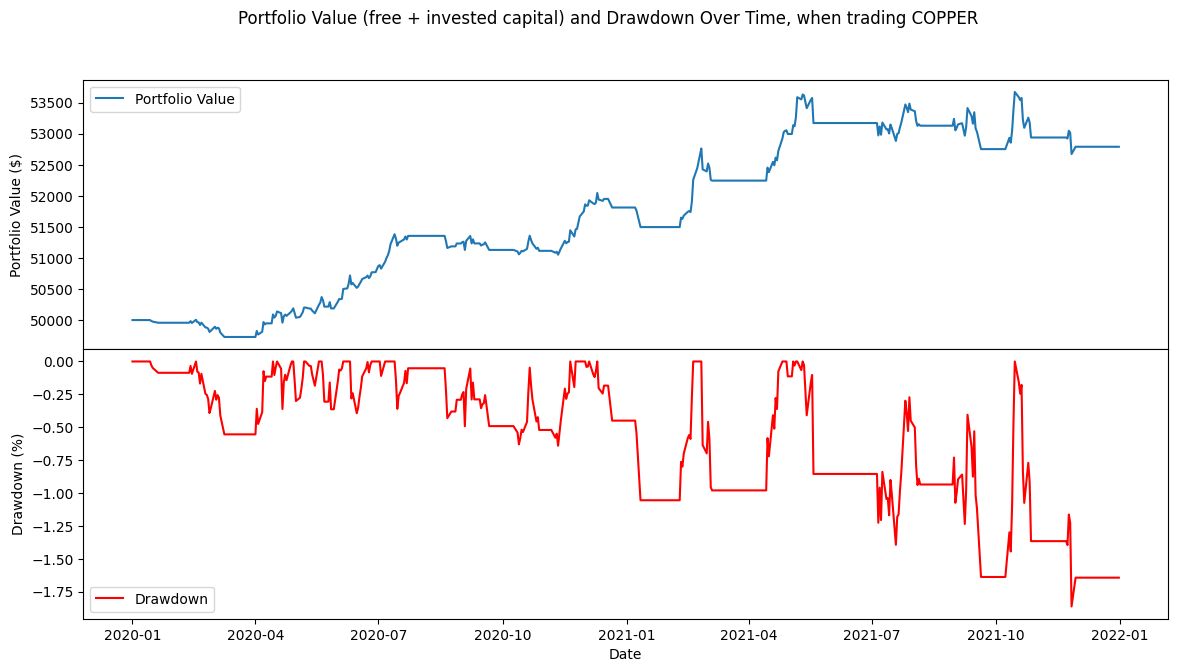

In [9]:
### Parameters ###

data_path = f"{os.pardir}/data/MarketData.csv"
# Metal to be used for the simulation
metal = "COPPER"
# Date range for backtesting
start_date = "2020-01-01"
end_date = "2021-12-31"
# Periods to evaluate the performance metrics for
periods = [
    ("2020-01-01", "2020-12-31"),
    ("2021-01-01", "2021-12-31"),
    ("2020-01-01", "2021-12-31"),
]

# Load the data
df = get_metal_data(metal, start_date, end_date)

# Test strategy
df_simulation, df_trades = backtest_simulation(df, free_capital=50000)
logging.info("Backtest simulation completed.")
print(f"\nSimulation results (head):\n{df_simulation.head()}")
print(f"\nTrades made (head):\n{df_trades.head()}")
print(f"\nTotal trades made: {len(df_trades)}")

# Calculate metrics to be added to the simulation DataFrame
calculate_daily_returns(df_simulation)
calculate_drawdown(df_simulation)

# Calculate performance metrics table
df_performance = get_performance_metrics_table(df_simulation, df_trades, periods)
print(f"\nPerformance metrics:\n{df_performance}")

# Save the simulation results and its performance metrics
df_simulation.to_csv("tables/simulation_results.csv", index=False)
df_trades.to_csv("tables/trades_results.csv", index=False)
df_performance.to_csv("tables/performance_metrics.csv", index=False)
logging.info(
    "Simulation results, trades results and performance metrics saved in .csv format."
)

# Plot the drawdown over time
plot_drawdown_overtime(df_simulation, metal)